In [8]:
import sys
import os
from pathlib import Path

project_root = str(Path(os.getcwd()).parent)

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.augmentation import augment_training_set
from src.data_loader import unpack_and_resize_data

import os
import json
from datetime import datetime

import tensorflow as tf
import wandb
from datasets import load_dataset
from wandb.integration.keras import WandbCallback

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

from imblearn.over_sampling import SMOTE

In [3]:
dataset = load_dataset("garythung/trashnet")

## **Unpack and Resize Images**

To train a model, we need to make sure all images have the same shape, in this case we intent to make the model input (224, 224, 3).
- width: 224
- height: 224
- depth/pixel: 3 (RGB)

In [20]:
# Preprocess the data
X, y = unpack_and_resize_data(dataset['train'], target_size=(224, 224))

# Convert labels to categorical
num_classes = len(np.unique(y))
y = to_categorical(y, num_classes)


## **Train and Validation Splitting**

Because of the imbalance dataset, we use stratified in train_test_split to make the splits for each class still balanced across training set and validation set.

In [31]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## **Setup Wandb Logger for each Epochs**
To make custom logger that calculates train_loss, train_accuracy, val_loss, val_accuracy we can use this custom class

In [32]:
class WandbMetricsLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        wandb.log({
            'epoch': epoch,
            'train_loss': logs.get('loss', 0),
            'train_accuracy': logs.get('accuracy', 0),
            'val_loss': logs.get('val_loss', 0),
            'val_accuracy': logs.get('val_accuracy', 0),
            'learning_rate': float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        })

## **Modelling**

The best model architecture that i came up with is

- 3 Convolutional layers with 32:64:128 filters with 3x3 kernel size with padding=1, with each layer applied BatchNormalization to avoid overfitting and normalize the convoluted tensor. In each convolutional layer also applied MaxPooling with size of 2x2 to gain the representation of the matrix.

- 2 Dense Layers used to classify the image, the first Dense layer have 128 nodes and the second node have the ouput of the intended classified class which is 6.

- GlobalAveragePooling is used to flatten the layer instead of normal flatten layer. The difference between both is for example:
if we use Flatten for (10, 5, 5, 3) it will outputs (10, 75) but with GlobalAveragePool it will ouputs (10, 3). The reason is to essentially summarize feature maps that has been mapped by the Convolutional layer

- Dropout Layer is used to avoid overfitting


In [60]:
def create_model(num_classes):
    model = models.Sequential([
        # CNN layers
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Dense layers
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

## **Augment Image**

Data augmentation is used to make the dataset have variety. For example we can have other various of an image if we rotate, shift, flip, change it's brightness, and even zoom it in. Model learns better with this data augmentation.

In [33]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

## **Wandb**

To make a model reproducible is we need to log our training data. We use wandb to log to see our new model performance and adjust the training parameters/hyperparameters. 

In [61]:
BATCH_SIZE = 32

wandb.init(
    project="trashnet",  
    config={
        "learning_rate": 0.001,
        "epochs": 50,
        "batch_size": BATCH_SIZE,
        "architecture": {
            "conv_layers": 3,
            "dense_layers": 2,
            "flat layer": "Global Average Pool",
        },
        "optimizer": "adam",
        "loss": "categorical_crossentropy",
        "dataset": "trashnet",
        "num_classes": num_classes,
    },
    name="CPU-4 Convolutions, 2 Dense Layers, Global Average Pool, Dropout-0.3-Tensorflow",
)

model = create_model(num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=wandb.config.learning_rate)
model.compile(
    optimizer=optimizer,
    loss=wandb.config.loss,
    metrics=['accuracy']    
)

c:\Users\radit\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## **Prepare training datasets**

In [62]:
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=wandb.config.batch_size,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val, y_val,
    batch_size=wandb.config.batch_size,
    shuffle=False
)

## **Setup Callbacks**

Callbacks is used to monitor, modify or takes action during training. In this case we use EarlyStopping and save the best weights if the val_loss increases in 5 epochs, reduce learning rates by 0.2 if val_loss increases in 3 epochs, and save model checkpoint if val_accuracy is going down

In [63]:
callbacks = [
    WandbMetricsLogger(),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

In [ ]:

history = model.fit(
    train_generator,
    epochs=wandb.config.epochs,
    validation_data=val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE),
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)),
    callbacks=callbacks,
)


c:\Users\radit\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 112s 865ms/step - accuracy: 0.3945 - loss: 1.7117 - val_accuracy: 0.2611 - val_loss: 1.8402 - learning_rate: 0.0010
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 111s 869ms/step - accuracy: 0.5363 - loss: 1.2627 - val_accuracy: 0.2127 - val_loss: 2.3384 - learning_rate: 0.0010
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 108s 848ms/step - accuracy: 0.5640 - loss: 1.1625 - val_accuracy: 0.2324 - val_loss: 1.9813 - learning_rate: 0.0010
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 112s 880ms/step - accuracy: 0.6057 - loss: 1.0696 - val_accuracy: 0.2997 - val_loss: 2.2214 - learning_rate: 0.0010
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.6270 - loss: 1.0021 - val_accuracy: 0.4768 - val_loss: 1.5138 - learning_rate: 2.0000e-04
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 119s 931ms/step - accuracy: 0.6648 - loss: 0.9312 - val_accuracy: 0.5648 - val_loss: 1.0761 - learning_rate: 2.0000e-04
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 109s 853ms/step - a

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


c:\Users\radit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
              precision    recall  f1-score   support

   cardboard       0.10      0.22      0.14       176
       glass       0.00      0.00      0.00       216
       metal       0.67      0.09      0.15       164
       paper       0.25      0.65      0.36       220
     plastic       0.00      0.00      0.00       179
       trash       0.09      0.04      0.05        56

    accuracy                           0.20      1011
   macro avg       0.18      0.17      0.12      1011
weighted avg       0.18      0.20      0.13      1011


Overall Metrics:
F1-Score (weighted): 0.1300
Precision (weighted): 0.1850
Recall (weighted): 0.1958


c:\Users\radit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\radit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\radit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

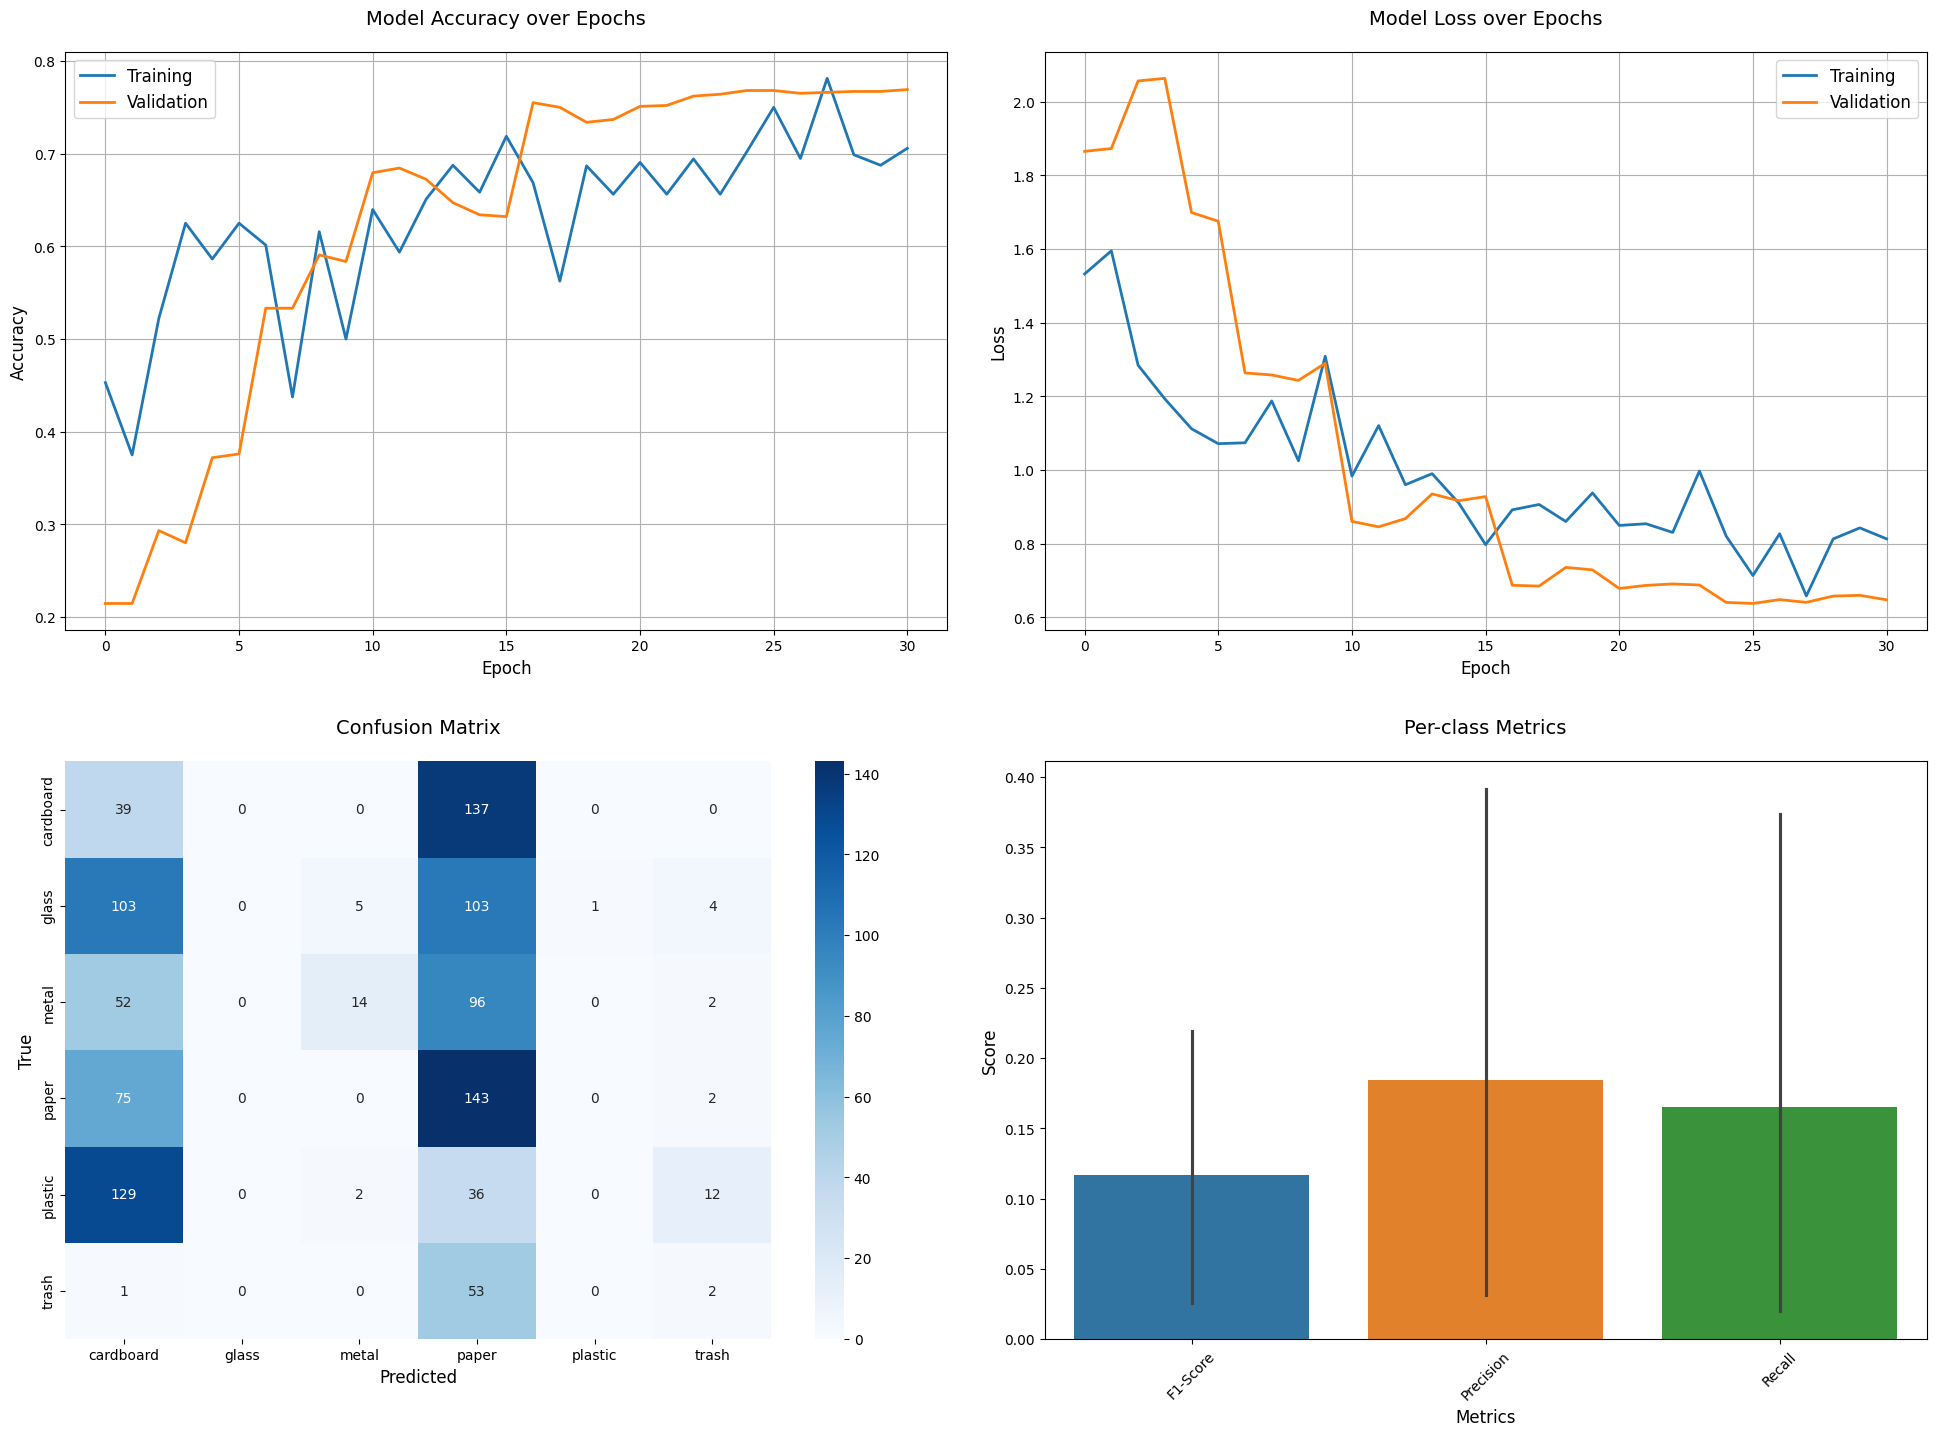

In [32]:
dataset_info = dataset['train'].features
class_names = dataset_info['label'].names

def analyze_trashnet_model(model, history, X_val, y_val):
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Training & Validation Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Training', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    plt.title('Model Accuracy over Epochs', fontsize=14, pad=20)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    
    # 2. Training & Validation Loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Training', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
    plt.title('Model Loss over Epochs', fontsize=14, pad=20)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    
    # Get predictions
    y_val_classes = np.argmax(y_val, axis=1)
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # 3. Confusion Matrix
    plt.subplot(2, 2, 3)
    cm = confusion_matrix(y_val_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=14, pad=20)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    
    # 4. Per-class Metrics
    plt.subplot(2, 2, 4)
    metrics_df = pd.DataFrame({
        'F1-Score': f1_score(y_val_classes, y_pred_classes, average=None),
        'Precision': precision_score(y_val_classes, y_pred_classes, average=None),
        'Recall': recall_score(y_val_classes, y_pred_classes, average=None)
    }, index=class_names)
    
    sns.barplot(data=metrics_df)
    plt.title('Per-class Metrics', fontsize=14, pad=20)
    plt.xlabel('Metrics', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.xticks(rotation=45)
    
    # Adjust layout
    plt.tight_layout(pad=3.0)
    
    # Print detailed metrics
    print("\nClassification Report:")
    print(classification_report(y_val_classes, y_pred_classes, target_names=class_names))
    
    # Calculate and print overall metrics
    print("\nOverall Metrics:")
    print(f"F1-Score (weighted): {f1_score(y_val_classes, y_pred_classes, average='weighted'):.4f}")
    print(f"Precision (weighted): {precision_score(y_val_classes, y_pred_classes, average='weighted'):.4f}")
    print(f"Recall (weighted): {recall_score(y_val_classes, y_pred_classes, average='weighted'):.4f}")
    
    # Log metrics to wandb
    wandb.log({
        "confusion_matrix": wandb.plot.confusion_matrix(
            y_true=y_val_classes,
            preds=y_pred_classes,
            class_names=class_names
        ),
        "f1_score": f1_score(y_val_classes, y_pred_classes, average='weighted'),
        "precision": precision_score(y_val_classes, y_pred_classes, average='weighted'),
        "recall": recall_score(y_val_classes, y_pred_classes, average='weighted')
    })
    
    return fig

fig = analyze_trashnet_model(model, history, X_val, y_val)
plt.show()

## **Post Training Analysis**

- Accuracy and Loss: from this plot we can see if the model still haven't predict 25% of the validation data, the val_accuracy and training_accuracy is not too far apart means the model is not overfitting. But the training_accuracy is lower and both training accuracy and loss stucks which means the model is underfitting. 
- Confusion Matrix: from this plot we can learn the model is classifying paper a lot which is not good. But this is expected because of the imbalance dataset

## **Recommendation**

For next training we need to handle imbalance dataset. we can do one of these:
- class weighthing: class that has higher sample will have lower class weights
- lower class data augmentation: we can augment only the class has lower sample instead of all class data augmentation
- GAN: Generative Adversarial Network can help to make new dataset based on the previous data we own

## **Logging**


In [20]:
def log_model_to_wandb(model, config, metrics, model_version):
    model_name = f"trashnet_model_v{model_version}"
    artifact = wandb.Artifact(
        name=model_name,
        type="model",
        description="Trashnet Classification model",
        metadata=config
    )
    
    # Save model locally first
    model_dir = "model_artifacts"
    os.makedirs(model_dir, exist_ok=True)
    
    # Save model in Keras format
    keras_model_path = os.path.join(model_dir, f"{model_name}.keras") 
    model.save(keras_model_path)
    
    # Save config
    config_path = os.path.join(model_dir, "config.json")
    with open(config_path, "w") as f:
        json.dump(config, f, indent=4)
    
    # Save metrics
    metrics_path = os.path.join(model_dir, "metrics.json")
    with open(metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)
    
    # Create README with model info
    readme_path = os.path.join(model_dir, "README.md")
    with open(readme_path, "w") as f:
        f.write(f"# Trash Classification Model\n\n")
        f.write(f"Created on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write("## Model Architecture\n```\n")

        f.write("```\n\n")
        f.write("## Metrics\n")
        for key, value in metrics.items():
            f.write(f"- {key}: {value}\n")
    
    # Add files to artifact
    artifact.add_dir(model_dir)
    
    # Log artifact to wandb
    wandb.log_artifact(artifact)
    
    return artifact

In [33]:
model_version = "1.4"

final_metrics = {
    'final_train_loss': history.history['loss'][-1],
    'final_train_accuracy': history.history['accuracy'][-1],
    'final_val_loss': history.history['val_loss'][-1],
    'final_val_accuracy': history.history['val_accuracy'][-1],
    'total_epochs': len(history.history['loss'])
}

final_artifact = log_model_to_wandb(
    model,
    wandb.config.as_dict(),
    final_metrics,
    model_version
)

wandb.finish()

wandb: Adding directory to artifact (.\model_artifacts)... Done. 2.0s


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
f1_score,▁
learning_rate,████▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁
recall,▁
train_accuracy,▂▁▄▅▅▅▅▂▅▃▆▅▆▆▆▇▆▄▆▆▆▆▇▆▇▇▇█▇▆▇
train_loss,██▆▅▄▄▄▅▄▆▃▄▃▃▃▂▃▃▃▃▂▂▂▄▂▁▂▁▂▂▂
val_accuracy,▁▁▂▂▃▃▅▅▆▆▇▇▇▆▆▆███████████████
val_loss,▇▇██▆▆▄▄▄▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
f1_score,0.12999


In [22]:
def save_model(version, model, config, metrics, base_dir="../models"):
    model_dir = os.path.join(base_dir, f"model_{version}")
    os.makedirs(model_dir, exist_ok=True)
    
    # Save model weights and architecture
    keras_model_path = os.path.join(model_dir, f"model_{version}.keras") 
    model.save(keras_model_path)
    
    
    # Save configs
    config_path = os.path.join(model_dir, "config.json")
    with open(config_path, "w") as f:
        json.dump(config, f, indent=4)
    
    # Save metrics
    metrics_path = os.path.join(model_dir, "metrics.json")
    with open(metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)
    
    # Create README
    readme_path = os.path.join(model_dir, "README.md")
    with open(readme_path, "w") as f:
        f.write(f"""---
datasets:
- garythung/trashnet
metrics:
- accuracy
pipeline_tag: image-classification
---
""")
        f.write(f"\n# Model Version {version}\n")
        f.write(f"Created on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write("## Metrics\n")
        for key, value in metrics.items():
            f.write(f"- *{key}*: {value:.4f}\n")
        
        f.write("\n## Configuration\n")
        for key, value in config.items():
            f.write(f"- **{key}**: {value}\n")
    
    print(f"Model version {version} saved successfully at {model_dir}.")
    return model_dir

In [23]:
config = {
    "architecture": "3 Convolutional Layers, 2 Dense Layers, Global Average Pooling, Dropout 0.3",
    "input_size": (224, 224, 3),
    "num_classes": num_classes,
    "augmentation": {
        "rotation_range": 20,
        "width_shift_range": 0.2,
        "height_shift_range": 0.2,
        "horizontal_flip": True,
        "vertical_flip": True,
        "shear_range": 0.2,
        "brightness_range": [0.8, 1.2]
    },
    "optimizer": "adam",
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 50
}
    
final_metrics = {
    "train_loss": history.history['loss'][-1],
    "train_accuracy": history.history['accuracy'][-1],
    "val_loss": history.history['val_loss'][-1],
    "val_accuracy": history.history['val_accuracy'][-1]
}

save_model(model_version, model, config, final_metrics)

Model version 1.3 saved successfully at ../models\model_1.3.


'../models\\model_1.3'